In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [14]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
183
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40, 71, 127]
f_atom_fraction outliers indexes: [124]
FPSA3 outliers indexes: [40]
sasa outliers indexes: [127]
PNSA5 outliers indexes: [37, 38]
distance_between_atoms_in_f_group_centers outliers indexes: [35]
logP outliers indexes: [82, 83]
Remains rows:169, amount of features: 40
144 25


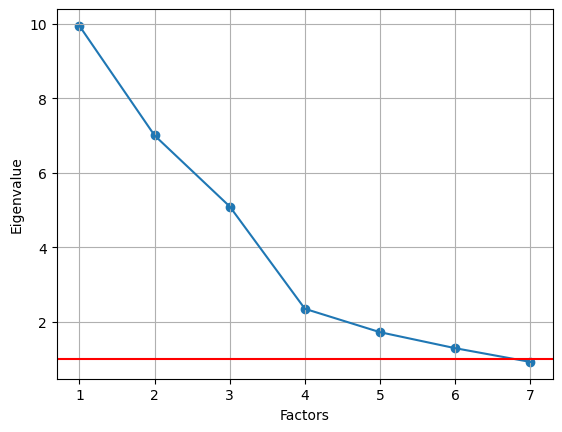

In [15]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [16]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6942585932459953

In [17]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: 19409.44442731222, p-value: 0.0


In [18]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
RPCS,-0.197432,0.254085,0.002828,-0.631577,-0.053950,0.055414,0.046007
PBF,-0.010475,0.003258,0.659612,0.158549,0.285385,0.096607,-0.082253
mol_weight,0.351087,-0.349774,0.290437,0.608492,0.540480,0.051465,0.013626
dipole_moment,0.362917,-0.174560,-0.015603,0.579299,-0.009029,0.003405,0.040174
PPSA5,0.056572,-0.845857,-0.028662,0.395162,0.197541,0.053894,0.074503
avg_atoms_in_cycle,0.479092,0.137945,-0.030350,-0.166312,0.579379,-0.087594,0.195887
nHRing,0.120171,0.410693,0.448625,-0.078427,-0.049793,-0.226123,0.697412
cis/trans,0.227242,-0.187236,-0.033711,-0.099784,-0.076563,0.745244,-0.129767
dihedral_angle,0.676795,-0.014416,-0.006862,0.069064,0.066307,0.116177,-0.089868
FPSA3,-0.121521,-0.774822,-0.197454,-0.438729,-0.206702,0.116227,-0.051580


Amount of feature: dihedral_angle: 105
R^2 score: 0.002457769767543925
{'mse': 4621.351, 'mae': 59.565, 'r_score': 0.002}


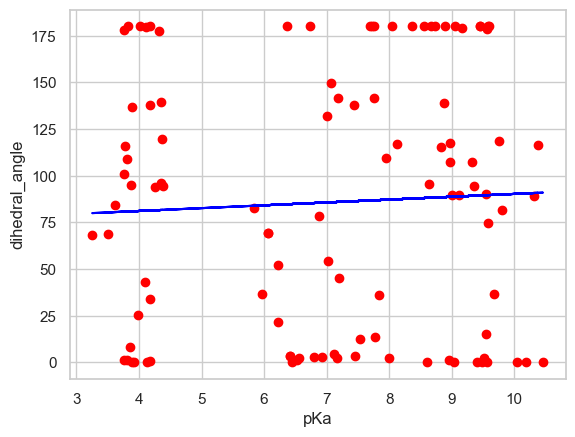

Amount of feature: distance_between_atoms_in_cycle_and_f_group: 105
R^2 score: 0.06428149176494176
{'mse': 0.399, 'mae': 0.511, 'r_score': 0.064}


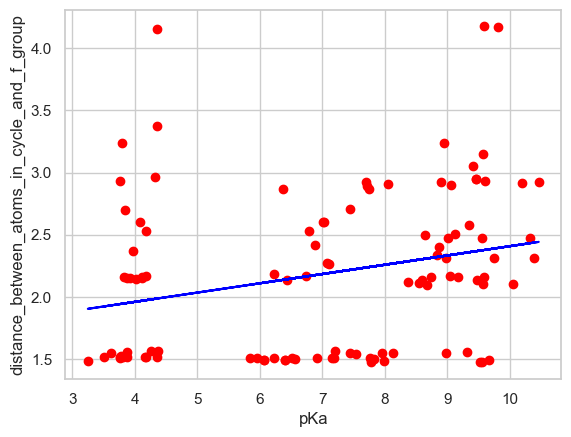

Amount of feature: angle_X1X2R2: 105
R^2 score: 0.0003986855261344632
{'mse': 274.286, 'mae': 14.959, 'r_score': 0.0}


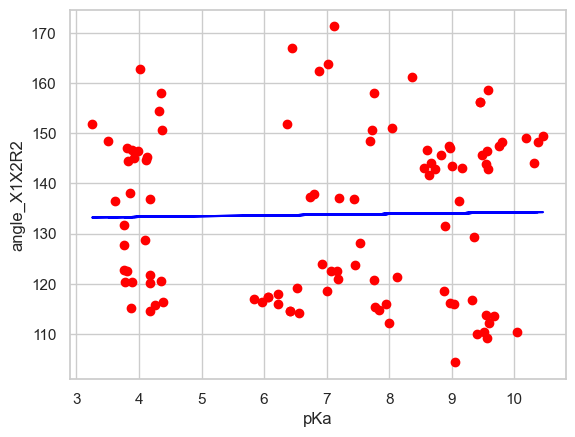

Amount of feature: angle_R1X1R2: 105
R^2 score: 0.016862329988633958
{'mse': 677.273, 'mae': 21.816, 'r_score': 0.017}


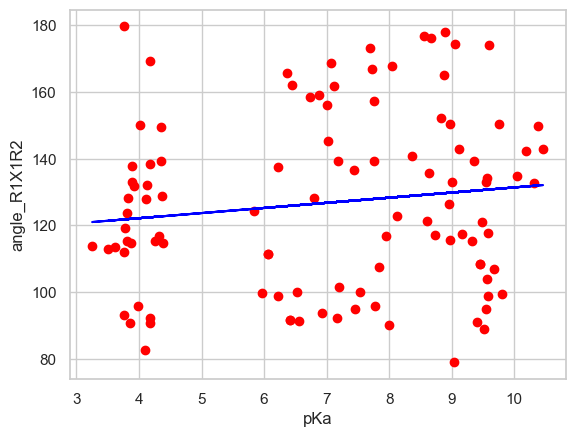

Amount of feature: angle_R2X2R1: 105
R^2 score: 0.0077394635832045
{'mse': 630.727, 'mae': 20.785, 'r_score': 0.008}


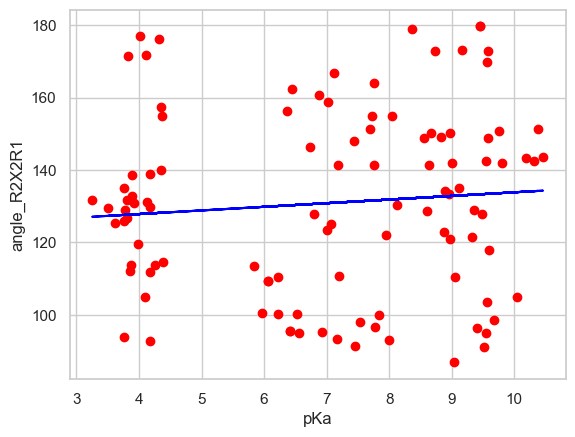

Amount of feature: distance_between_atoms_in_f_group_centers: 105
R^2 score: 0.032930050646661144
{'mse': 0.574, 'mae': 0.623, 'r_score': 0.033}


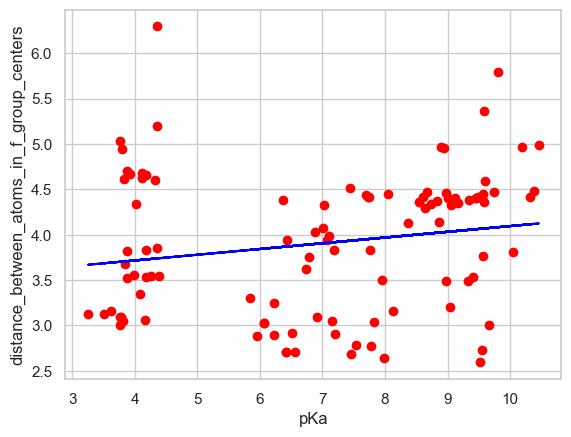

Amount of feature: angle_X2X1R1: 105
R^2 score: 0.03656684336509156
{'mse': 394.656, 'mae': 16.154, 'r_score': 0.037}


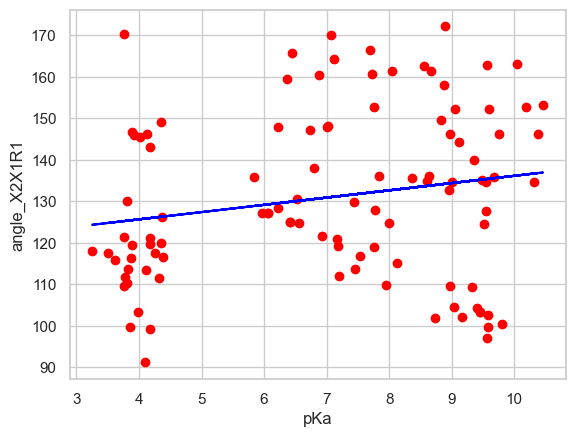

Amount of feature: f_to_fg: 6
Kruskal for f_to_fg: 21.97
P-value: 0.0005
There is a statistically significant difference between the groups


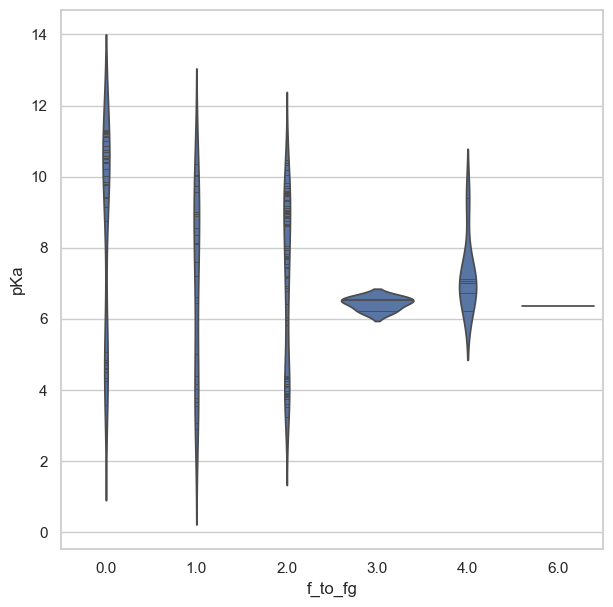

Amount of feature: PPSA5: 168
R^2 score: 0.829094265580821
{'mse': 0.928, 'mae': 0.736, 'r_score': 0.829}


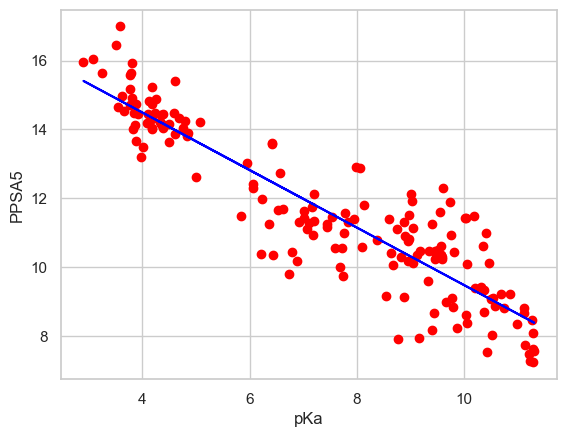

Amount of feature: FPSA3: 168
R^2 score: 0.20817350962510212
{'mse': 0.0, 'mae': 0.005, 'r_score': 0.208}


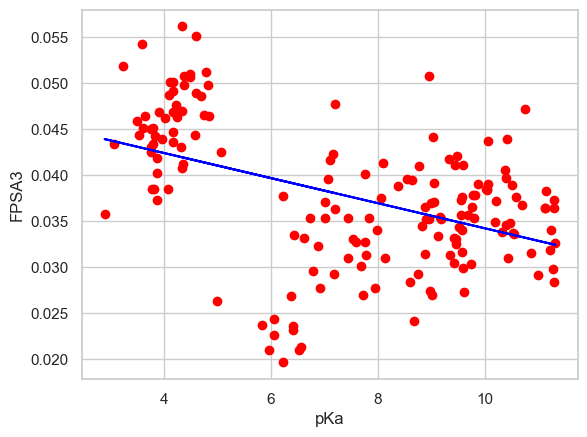

Amount of feature: PNSA5: 168
R^2 score: 0.6189248481442826
{'mse': 37.239, 'mae': 5.11, 'r_score': 0.619}


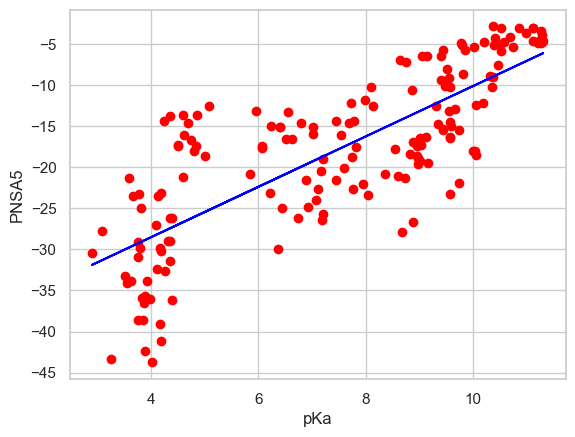

Amount of feature: TASA: 168
R^2 score: 0.2433531987095237
{'mse': 1793.273, 'mae': 33.317, 'r_score': 0.243}


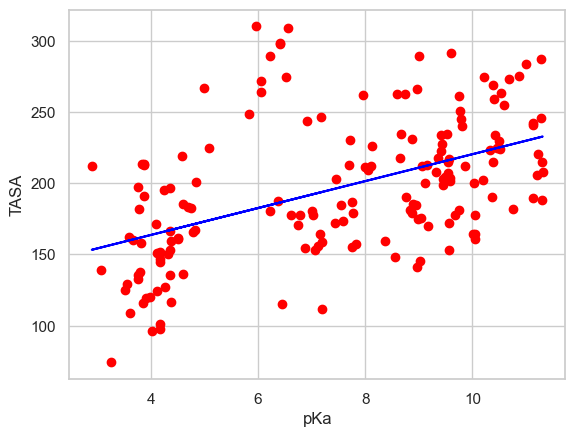

Amount of feature: nN: 2
Mann-Whitney U for nN: 1.00
P-value: 0.0000
There is a statistically significant difference between the groups


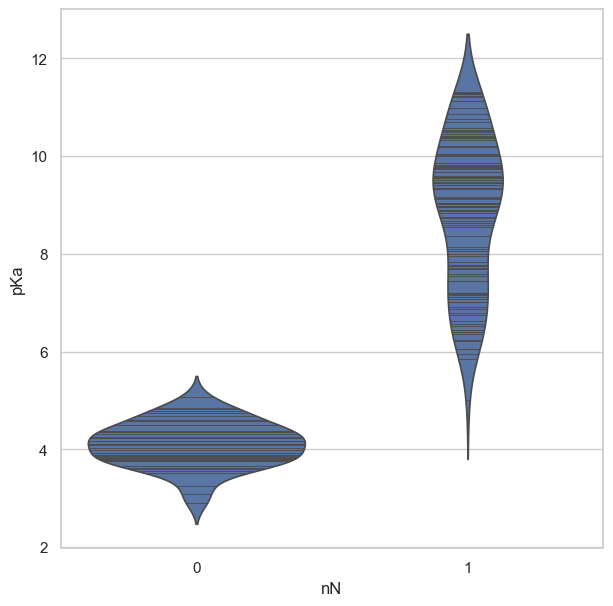

Amount of feature: identificator: 3
Kruskal for identificator: 104.97
P-value: 0.0000
There is a statistically significant difference between the groups


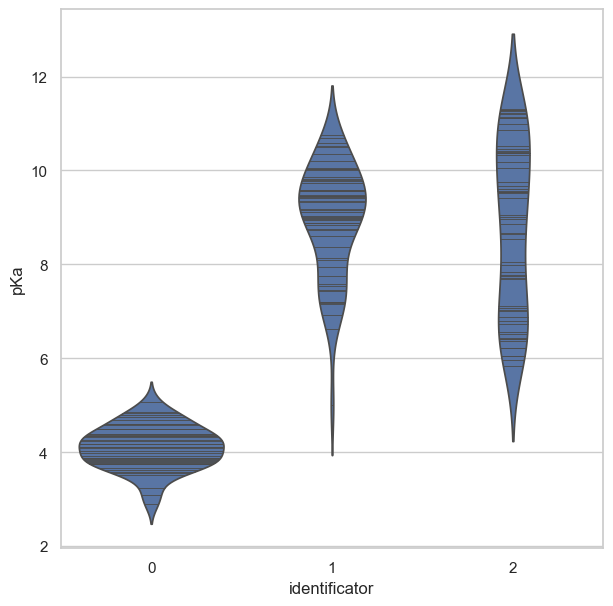

Amount of feature: nO: 4
Kruskal for nO: 105.16
P-value: 0.0000
There is a statistically significant difference between the groups


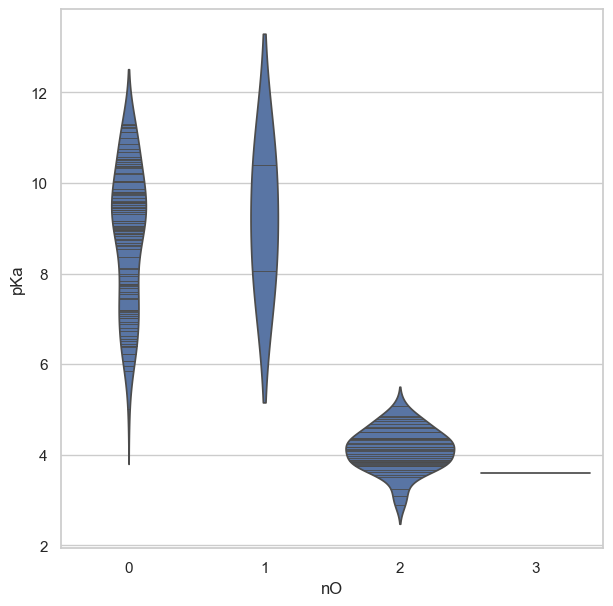

Amount of feature: PBF: 168
R^2 score: 0.0056837771283536195
{'mse': 0.009, 'mae': 0.08, 'r_score': 0.006}


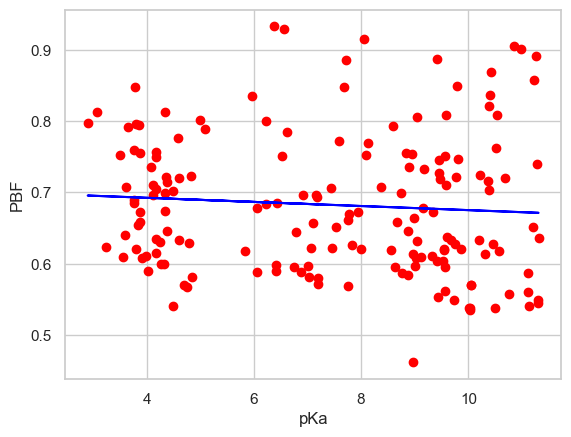

Amount of feature: mol_num_cycles: 4
Kruskal for mol_num_cycles: 4.79
P-value: 0.1877
There isn't any statistically significant difference between the groups


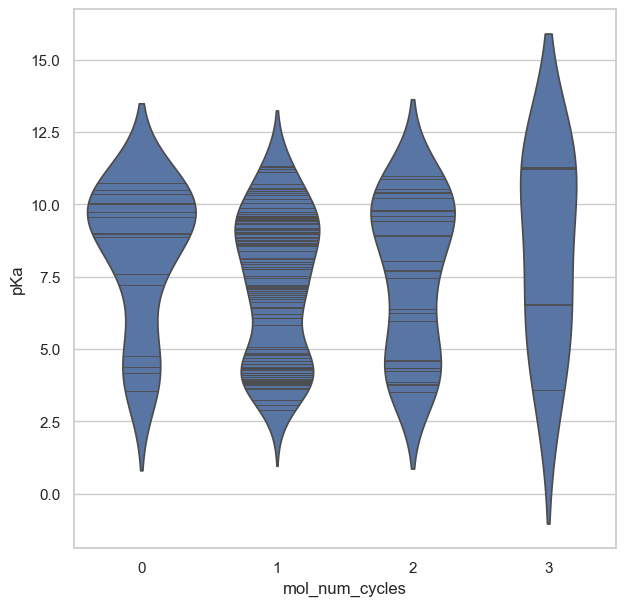

Amount of feature: nFRing: 2
Mann-Whitney U for nFRing: 1569.00
P-value: 0.1359
There isn't any statistically significant difference between the groups


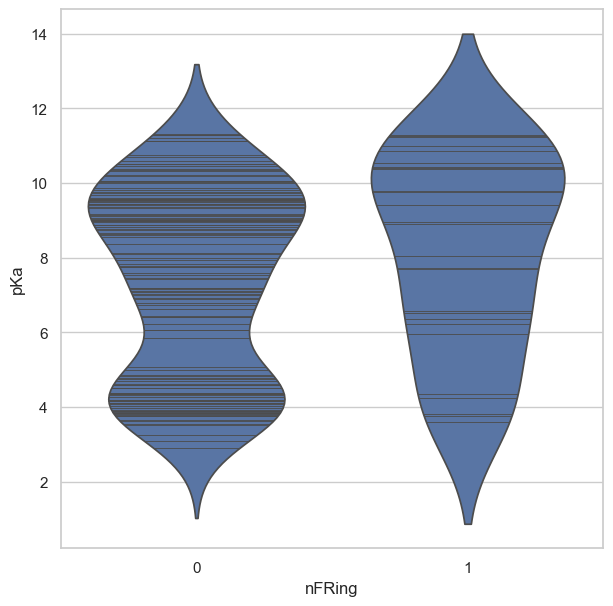

Amount of feature: nARing: 4
Kruskal for nARing: 4.79
P-value: 0.1877
There isn't any statistically significant difference between the groups


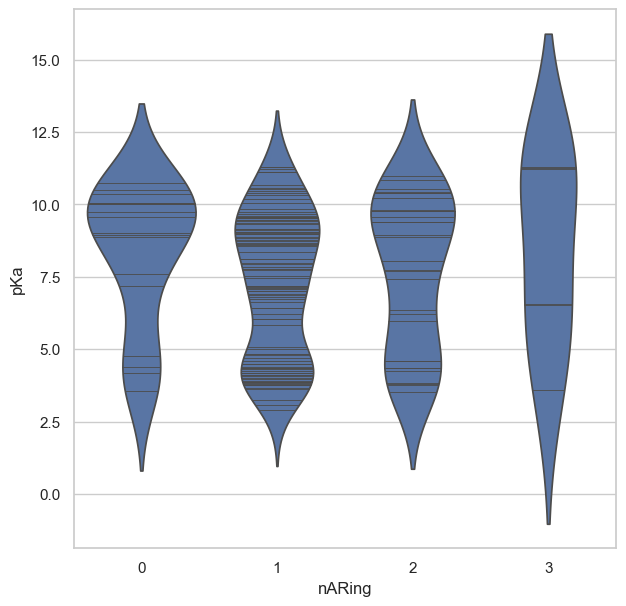

Amount of feature: nFHRing: 2
Mann-Whitney U for nFHRing: 960.00
P-value: 0.0208
There is a statistically significant difference between the groups


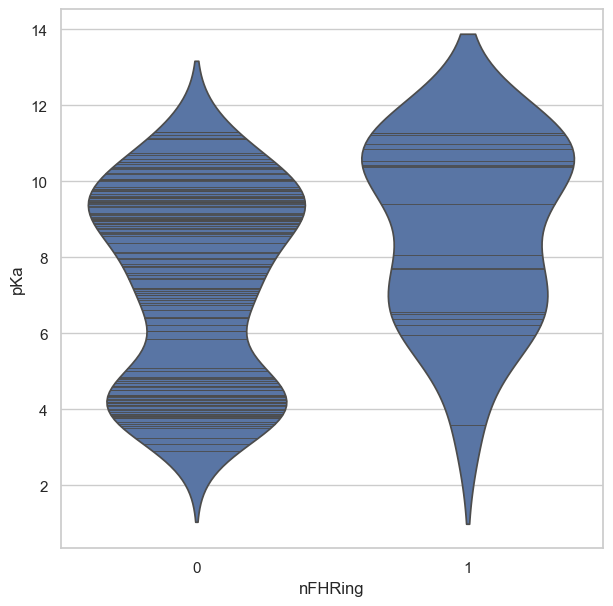

Amount of feature: RPCS: 150
R^2 score: 0.21961297292081638
{'mse': 1163.512, 'mae': 27.553, 'r_score': 0.22}


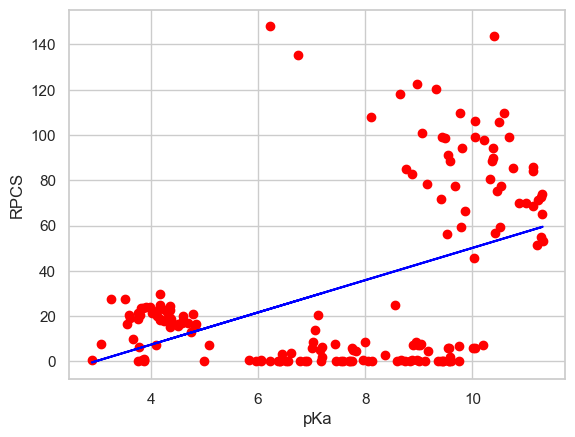

Amount of feature: mol_weight: 66
R^2 score: 0.3269640411347174
{'mse': 584.125, 'mae': 19.338, 'r_score': 0.327}


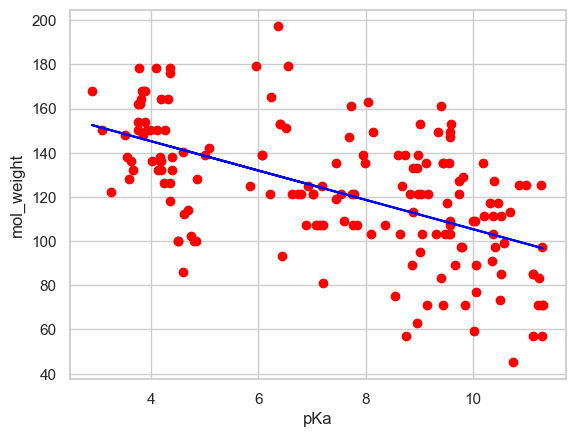

Amount of feature: nF: 5
Kruskal for nF: 31.94
P-value: 0.0000
There is a statistically significant difference between the groups


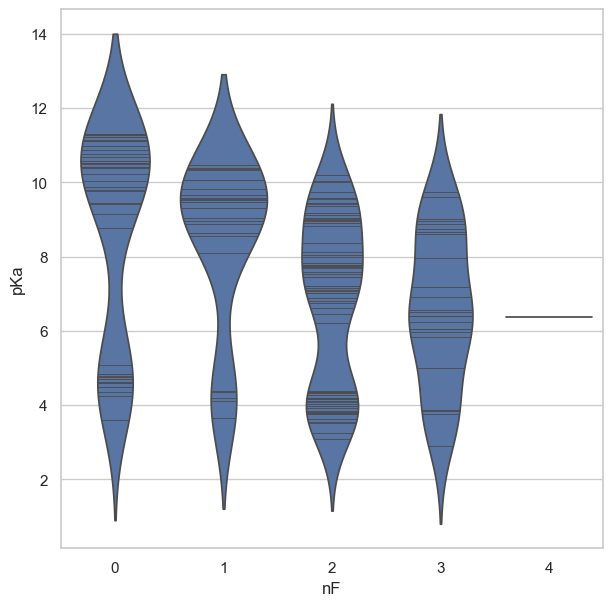

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 1926.00
P-value: 0.0000
There is a statistically significant difference between the groups


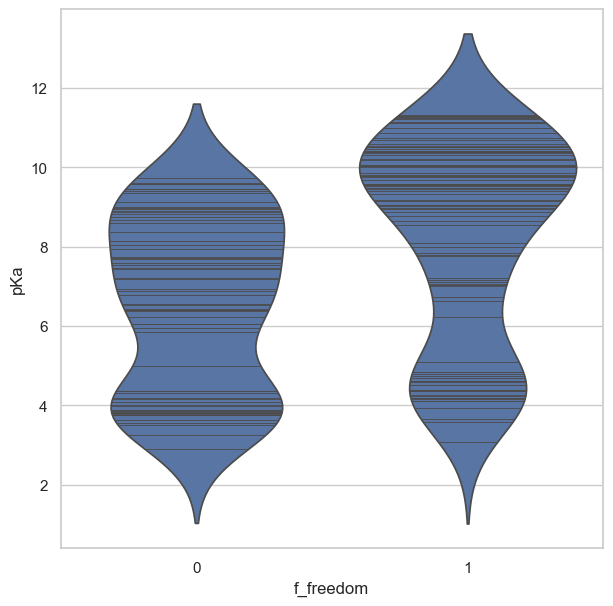

Amount of feature: sasa: 168
R^2 score: 0.06462134485835072
{'mse': 647.239, 'mae': 19.965, 'r_score': 0.065}


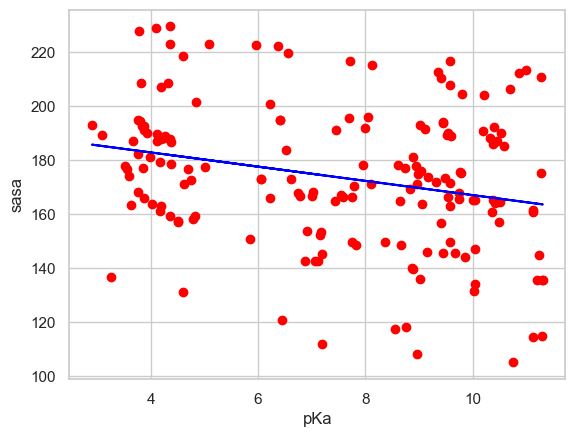

Amount of feature: nC: 7
Kruskal for nC: 14.51
P-value: 0.0244
There is a statistically significant difference between the groups


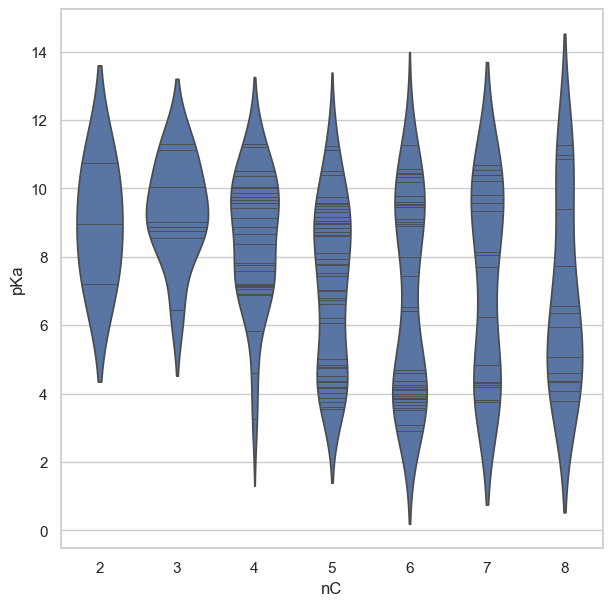

Amount of feature: cis/trans: 3
Kruskal for cis/trans: 11.01
P-value: 0.0041
There is a statistically significant difference between the groups


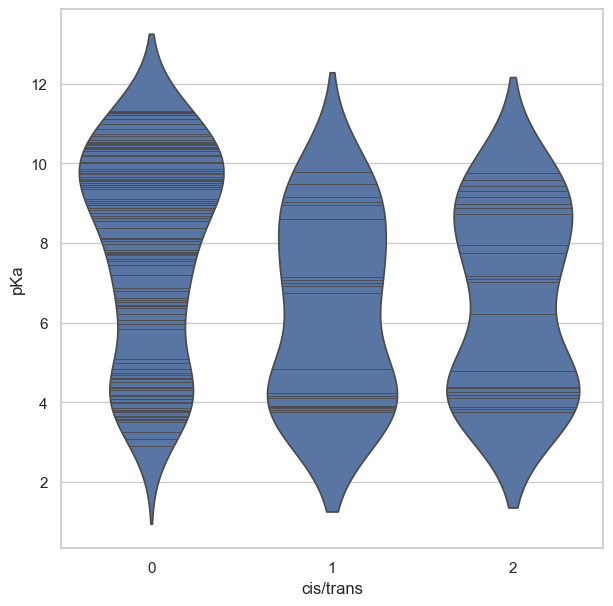

Amount of feature: chirality: 4
Kruskal for chirality: 6.12
P-value: 0.1060
There isn't any statistically significant difference between the groups


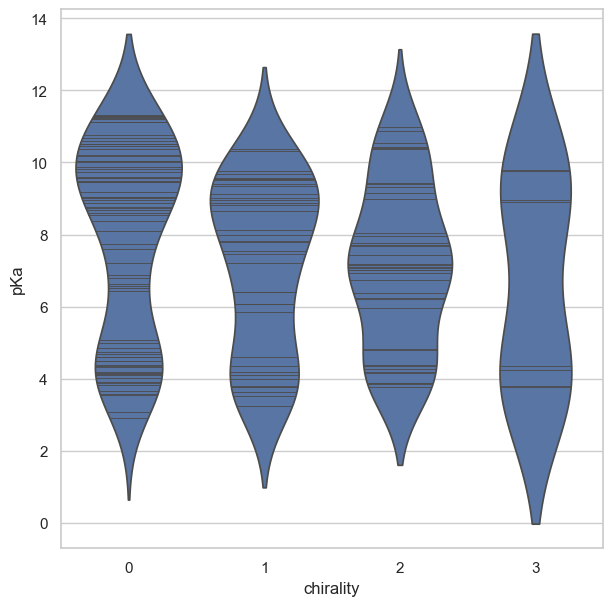

Amount of feature: nHRing: 3
Kruskal for nHRing: 21.23
P-value: 0.0000
There is a statistically significant difference between the groups


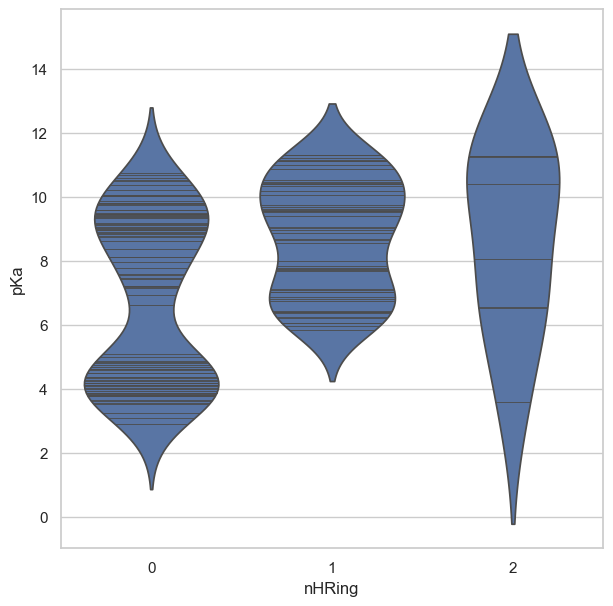

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.6:
            continue

        if feature_names[feature_index] == 'pKa':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, pKa repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            print(f"R^2 score: {pow(r, 2)}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('pKa')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['pKa']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='pKa',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                


-----

AMINE MOLECULES

-----------

In [23]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="amine",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
128
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
mol_weight outliers indexes: [28]
f_atom_fraction outliers indexes: [69]
distance_between_atoms_in_cycle_and_f_group outliers indexes: [112 113]
sasa outliers indexes: [72]
logP outliers indexes: [27]
Remains rows:118, amount of features: 40
feature without unique values: nN
100 18


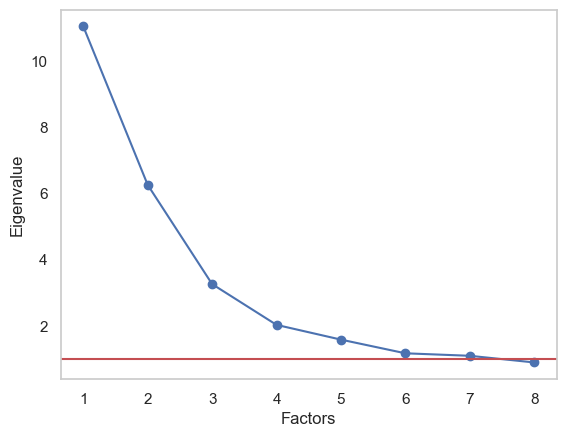

In [24]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

features_to_drop = ['nFARing', 'nFAHRing', 'nFHRing', 'nAHRing', 'fold_id']

for feature_to_drop in features_to_drop:
    if feature_to_drop in features_to_analyse:
        features_to_analyse.remove(feature_to_drop)

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [25]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7093127244211289

In [26]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
RPCS,-0.278339,-0.700087,-0.060731,-0.004098,0.122272,0.203792,0.157615
PBF,0.007623,0.045564,0.789401,0.260423,-0.049103,0.010376,0.121861
mol_weight,0.350849,0.645437,0.384493,0.554192,0.040758,-0.012468,0.047494
dipole_moment,0.304475,0.711525,-0.101316,0.076865,-0.034679,0.067331,0.075055
PPSA5,0.193131,0.867998,-0.118611,0.240203,-0.002254,0.073057,0.213159
avg_atoms_in_cycle,0.558126,-0.154956,-0.063522,0.514707,0.335273,0.057433,-0.110741
nHRing,0.084804,-0.034810,0.402730,0.007970,0.878476,-0.178313,0.113427
cis/trans,0.207535,0.005027,0.008694,-0.106933,-0.252853,0.716470,-0.049043
dihedral_angle,0.718873,0.091753,0.061378,0.012905,-0.101406,0.027222,-0.010989
FPSA3,-0.072102,-0.486834,-0.383245,-0.383119,-0.231235,0.185158,0.632536


Amount of feature: dihedral_angle: 73
R^2 score: 0.02396914462650156
{'mse': 4868.559, 'mae': 61.144, 'r_score': 0.024}


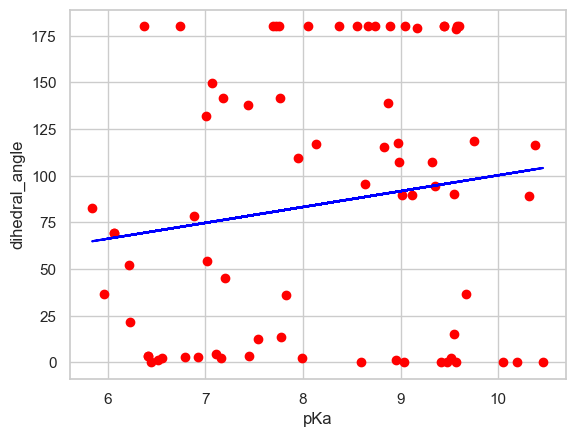

Amount of feature: distance_between_atoms_in_cycle_and_f_group: 73
R^2 score: 0.16524381184015147
{'mse': 0.258, 'mae': 0.438, 'r_score': 0.165}


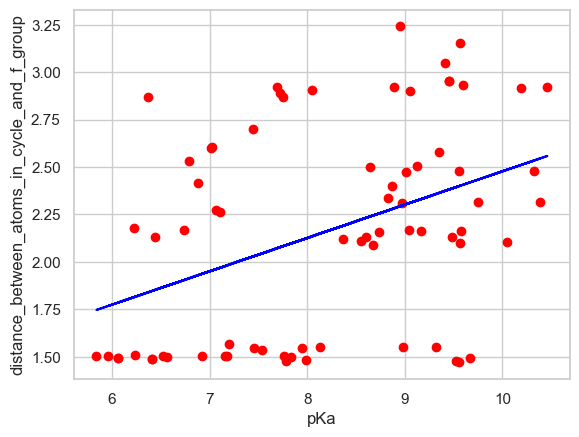

Amount of feature: angle_X1X2R2: 73
R^2 score: 0.017513418300631918
{'mse': 291.525, 'mae': 15.06, 'r_score': 0.018}


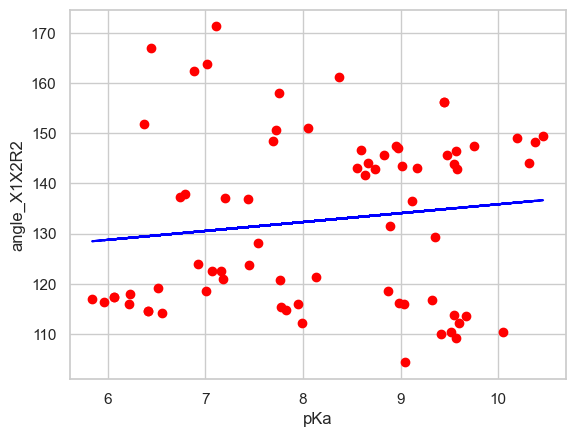

Amount of feature: angle_R1X1R2: 73
R^2 score: 0.01025132500756591
{'mse': 742.673, 'mae': 23.322, 'r_score': 0.01}


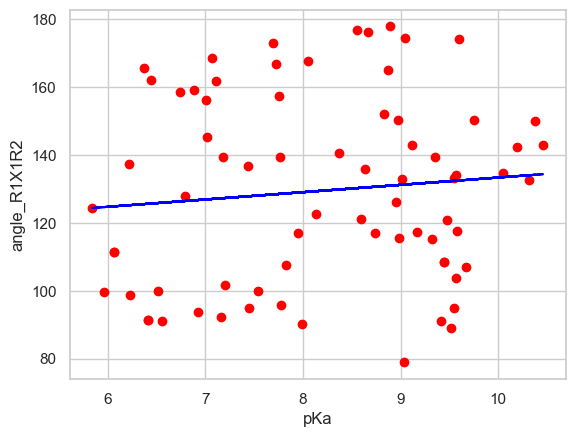

Amount of feature: angle_R2X2R1: 73
R^2 score: 0.0581515746280281
{'mse': 670.219, 'mae': 21.682, 'r_score': 0.058}


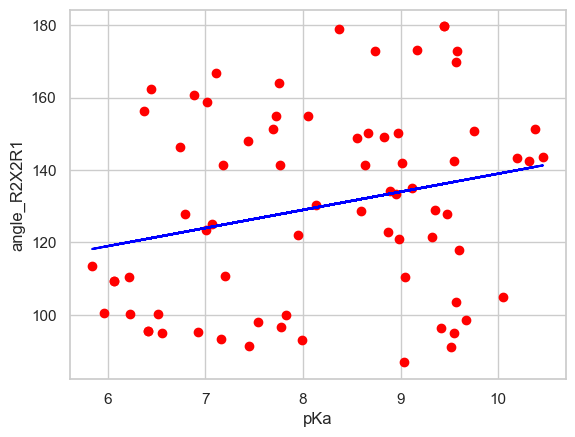

Amount of feature: distance_between_atoms_in_f_group_centers: 73
R^2 score: 0.2572779019908939
{'mse': 0.367, 'mae': 0.511, 'r_score': 0.257}


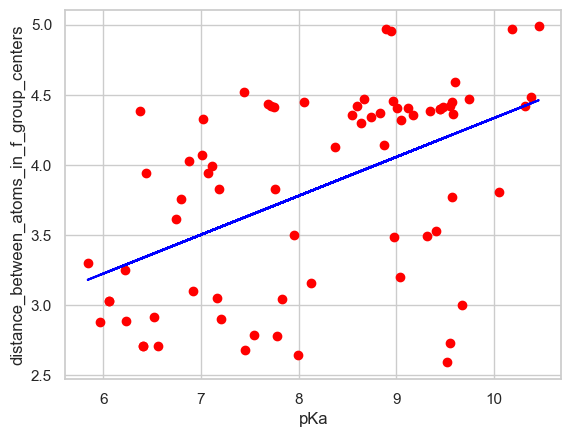

Amount of feature: angle_X2X1R1: 73
R^2 score: 0.0027270218538778548
{'mse': 388.85, 'mae': 16.551, 'r_score': 0.003}


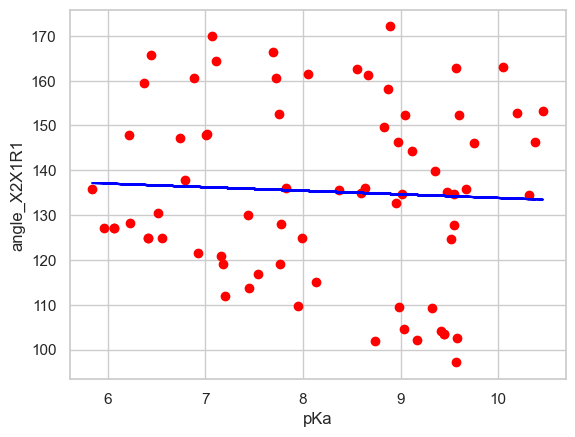

Amount of feature: f_to_fg: 6
Kruskal for f_to_fg: 61.38
P-value: 0.0000
There is a statistically significant difference between the groups


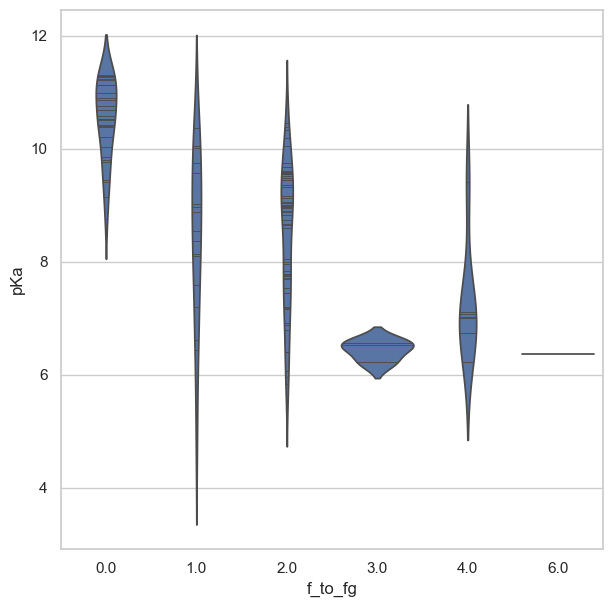

Amount of feature: RPCS: 100
R^2 score: 0.26456973207248813
{'mse': 1431.027, 'mae': 28.59, 'r_score': 0.265}


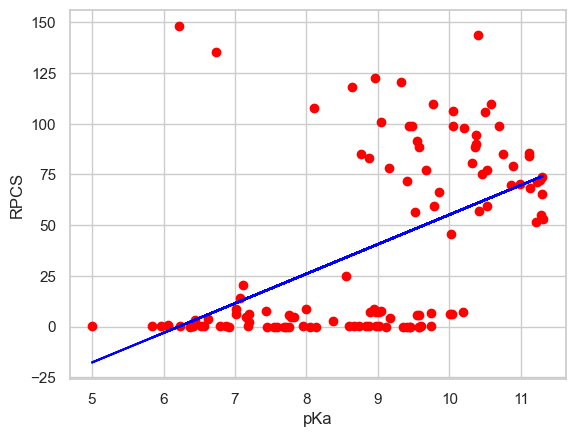

Amount of feature: mol_weight: 42
R^2 score: 0.25684741599883365
{'mse': 596.138, 'mae': 20.012, 'r_score': 0.257}


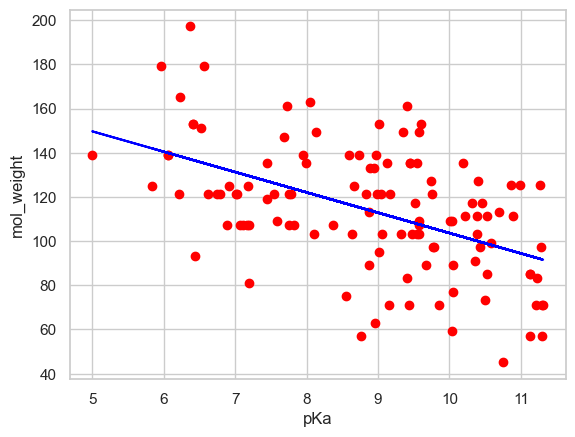

Amount of feature: dipole_moment: 117
R^2 score: 0.34263588574532217
{'mse': 0.014, 'mae': 0.095, 'r_score': 0.343}


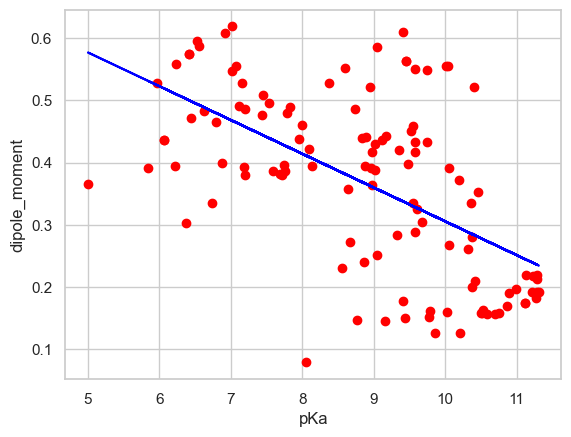

Amount of feature: PPSA5: 117
R^2 score: 0.5049696606110778
{'mse': 1.063, 'mae': 0.807, 'r_score': 0.505}


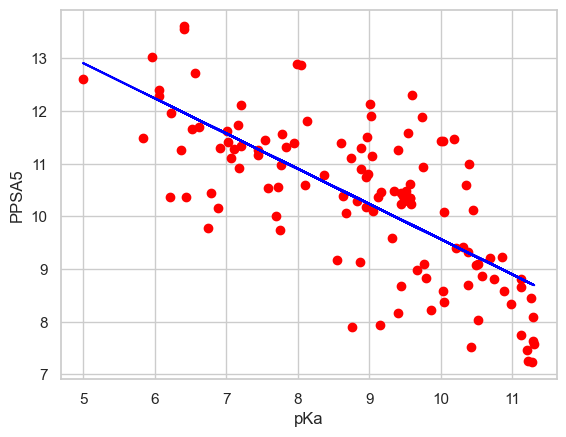

Amount of feature: nF: 5
Kruskal for nF: 70.01
P-value: 0.0000
There is a statistically significant difference between the groups


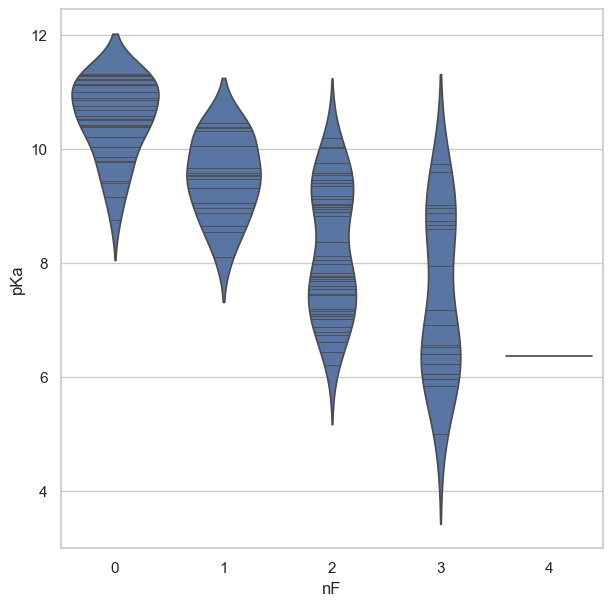

Amount of feature: PNSA5: 117
R^2 score: 0.4783729974296502
{'mse': 25.749, 'mae': 4.39, 'r_score': 0.478}


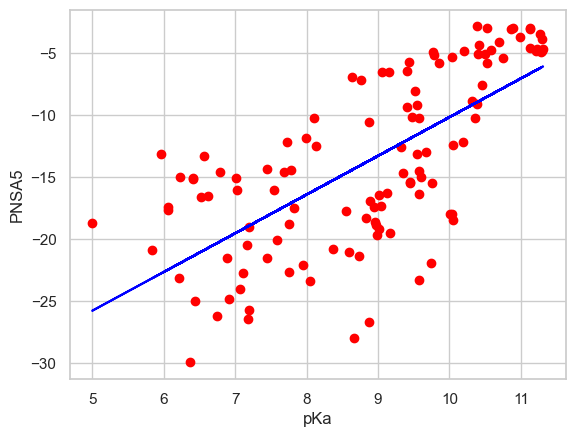

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 571.00
P-value: 0.0000
There is a statistically significant difference between the groups


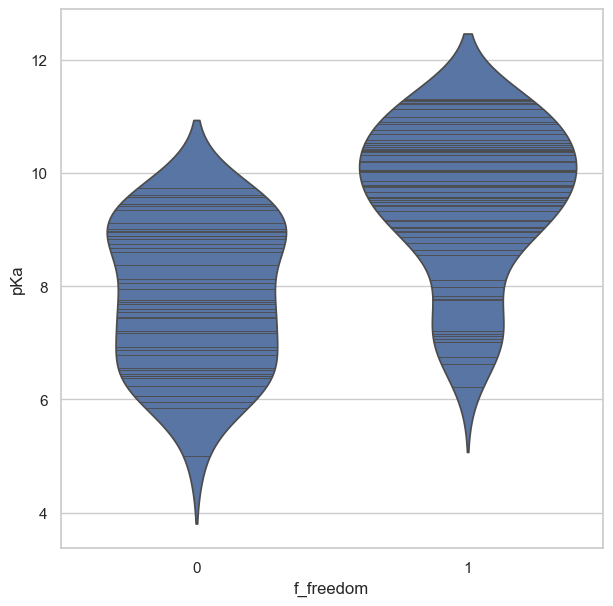

Amount of feature: PBF: 117
R^2 score: 0.0018337786453496837
{'mse': 0.012, 'mae': 0.089, 'r_score': 0.002}


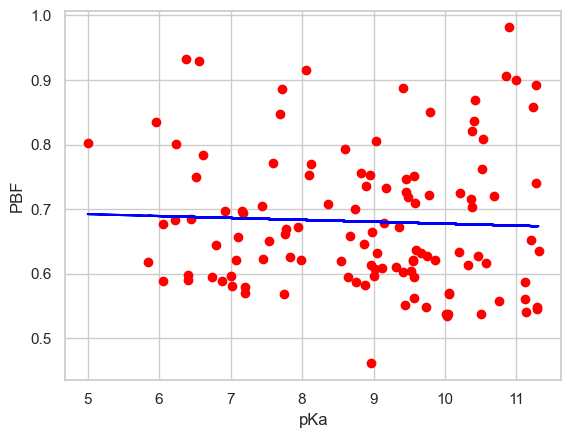

Amount of feature: mol_num_cycles: 4
Kruskal for mol_num_cycles: 5.85
P-value: 0.1190
There isn't any statistically significant difference between the groups


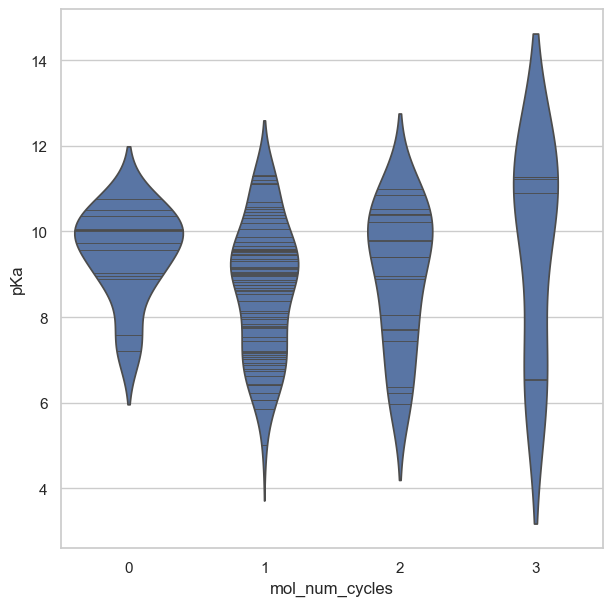

Amount of feature: nFRing: 2
Mann-Whitney U for nFRing: 922.00
P-value: 0.2481
There isn't any statistically significant difference between the groups


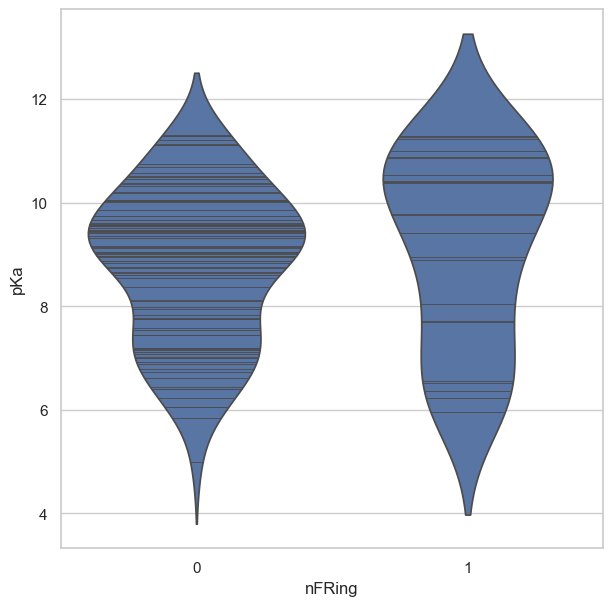

Amount of feature: nARing: 4
Kruskal for nARing: 5.85
P-value: 0.1190
There isn't any statistically significant difference between the groups


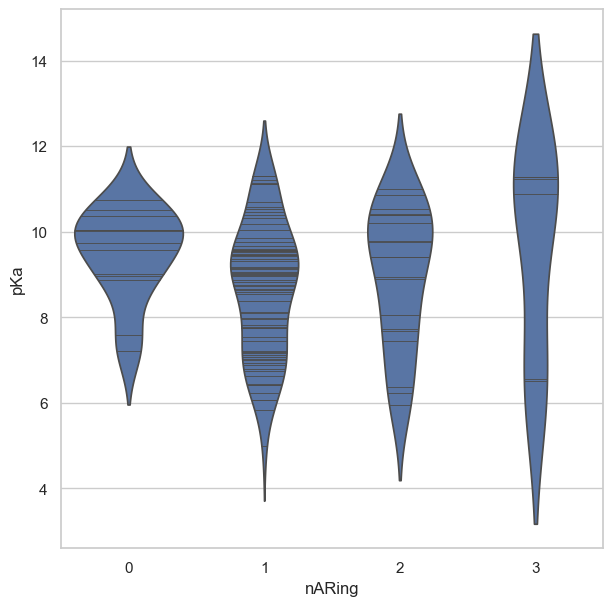

Amount of feature: nC: 7
Kruskal for nC: 5.72
P-value: 0.4558
There isn't any statistically significant difference between the groups


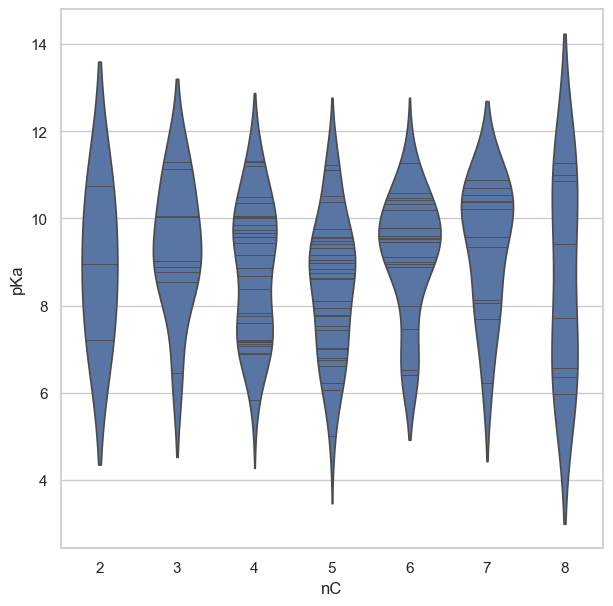

Amount of feature: sasa: 117
R^2 score: 0.0076469891195283185
{'mse': 692.68, 'mae': 20.612, 'r_score': 0.008}


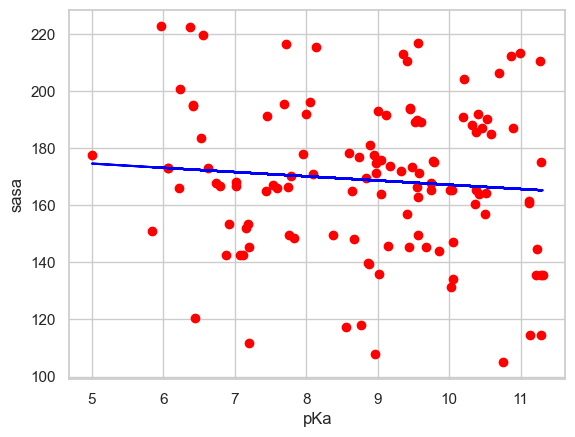

Amount of feature: nC: 7
Kruskal for nC: 5.72
P-value: 0.4558
There isn't any statistically significant difference between the groups


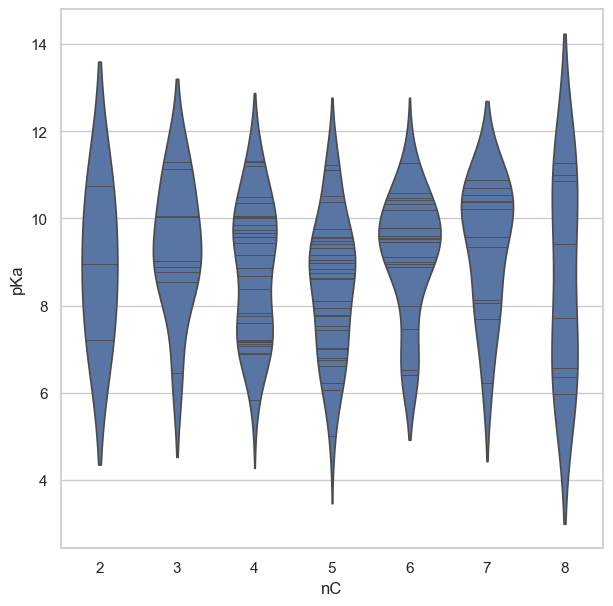

Amount of feature: nHRing: 3
Kruskal for nHRing: 2.24
P-value: 0.3263
There isn't any statistically significant difference between the groups


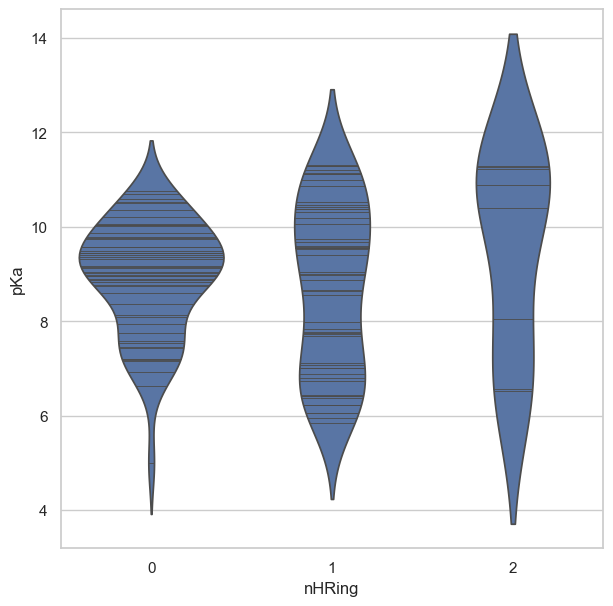

Amount of feature: identificator: 2
Mann-Whitney U for identificator: 1742.00
P-value: 0.9613
There isn't any statistically significant difference between the groups


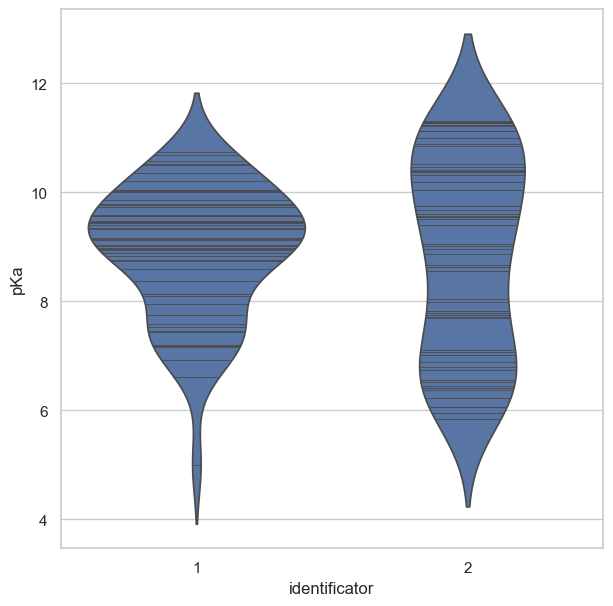

Amount of feature: cis/trans: 3
Kruskal for cis/trans: 5.85
P-value: 0.0537
There isn't any statistically significant difference between the groups


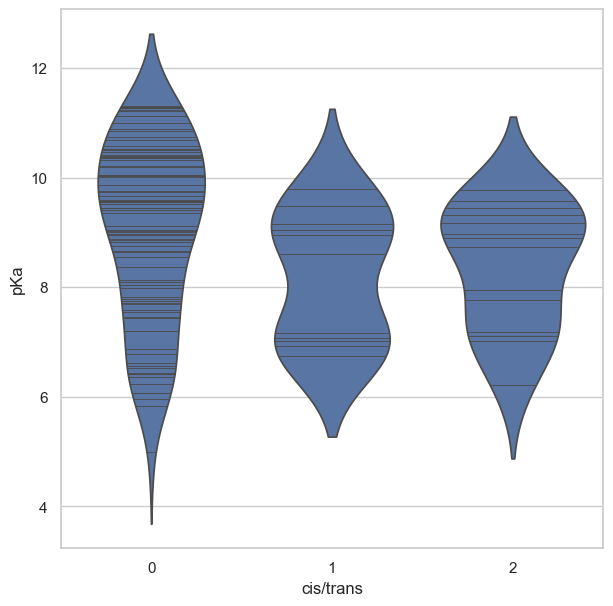

Amount of feature: FPSA3: 117
R^2 score: 0.14793366689987317
{'mse': 0.0, 'mae': 0.004, 'r_score': 0.148}


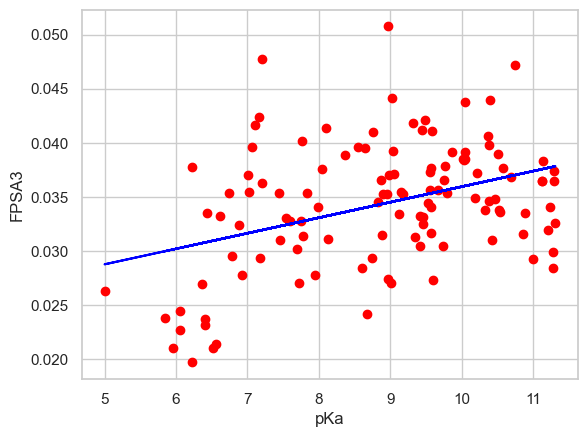

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.6:
            continue

        if feature_names[feature_index] == 'pKa':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, pKa repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            print(f"R^2 score: {pow(r, 2)}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('pKa')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['pKa']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='pKa',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                


-----

ACID MOLECULES

-----------

In [34]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="acid",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
55
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
RPCS outliers indexes: [9, 10, 11, 37, 41, 44, 45]
PBF outliers indexes: [40]
PPSA5 outliers indexes: [39, 40]
FPSA3 outliers indexes: [40]
GeomShapeIndex outliers indexes: [50]
logP outliers indexes: [48]
Remains rows:43, amount of features: 40
feature without unique values: nN
feature without unique values: identificator
36 7


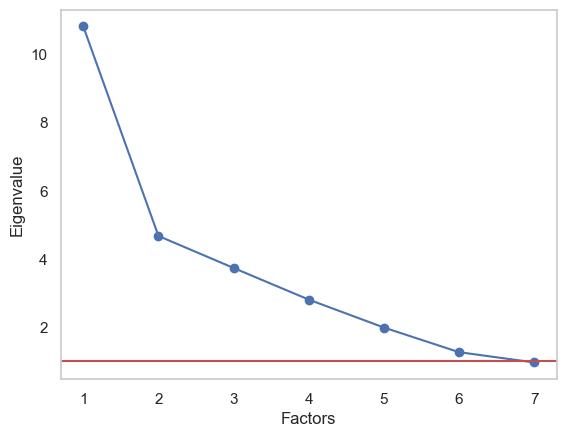

In [35]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

features_to_drop = ['nFARing', 'nFAHRing', 'nFHRing', 'nAHRing', 'fold_id']

for feature_to_drop in features_to_drop:
    if feature_to_drop in features_to_analyse:
        features_to_analyse.remove(feature_to_drop)

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [36]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.5486137740570619

In [39]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
RPCS,0.526457,-0.496784,0.157467,0.155458,0.222932,0.098433,-0.307551
PBF,-0.029678,0.321240,0.062942,-0.138685,0.188842,0.103988,0.733457
mol_weight,0.555441,0.628417,0.413856,0.250654,0.018855,0.051552,0.171378
dipole_moment,0.354603,-0.057608,0.647626,0.029449,-0.032980,0.078915,0.174475
PPSA5,0.076827,-0.002343,0.195355,0.316494,0.187292,-0.030897,0.511994
avg_atoms_in_cycle,0.235875,0.559708,-0.044514,-0.213891,0.034611,-0.138604,-0.114548
nHRing,0.085557,-0.017416,-0.024474,0.952562,0.218230,-0.043813,0.017305
cis/trans,0.287380,-0.152266,-0.428481,-0.083571,-0.086360,0.802224,0.015406
dihedral_angle,0.707496,0.138734,0.000665,-0.155036,-0.075220,0.063042,-0.089332
FPSA3,-0.118657,-0.745699,-0.523807,0.144631,0.084243,0.064129,-0.141120


Amount of feature: RPCS: 43
R^2 score: 0.04773898902061401
{'mse': 28.224, 'mae': 3.856, 'r_score': 0.048}


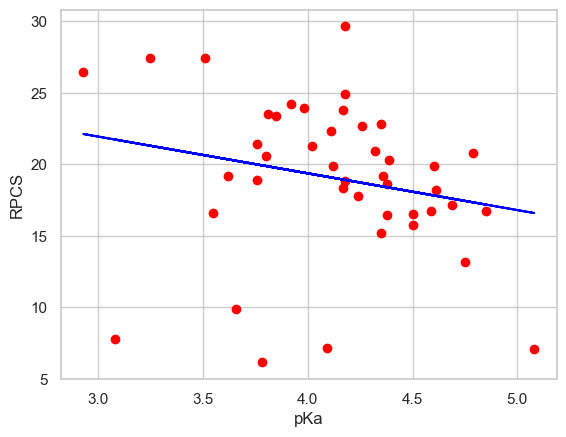

Amount of feature: mol_weight: 21
R^2 score: 0.20054113355360528
{'mse': 421.111, 'mae': 16.506, 'r_score': 0.201}


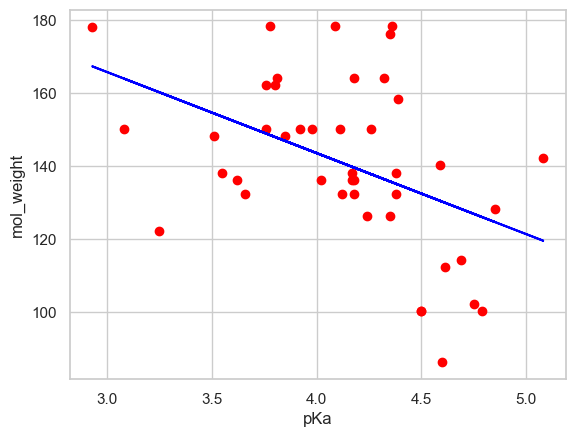

Amount of feature: dihedral_angle: 26
R^2 score: 0.09357757505484718
{'mse': 3522.551, 'mae': 49.805, 'r_score': 0.094}


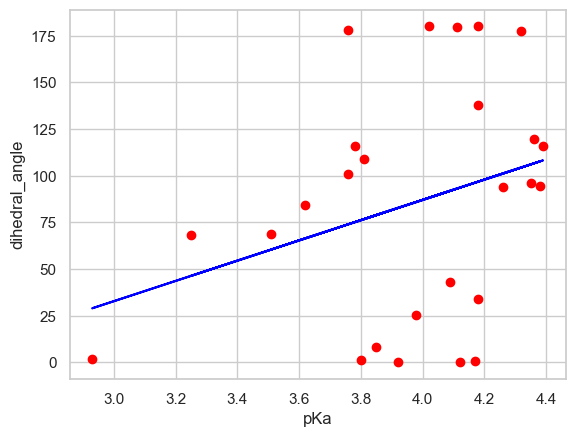

Amount of feature: distance_between_atoms_in_cycle_and_f_group: 26
R^2 score: 0.16402116033576128
{'mse': 0.523, 'mae': 0.591, 'r_score': 0.164}


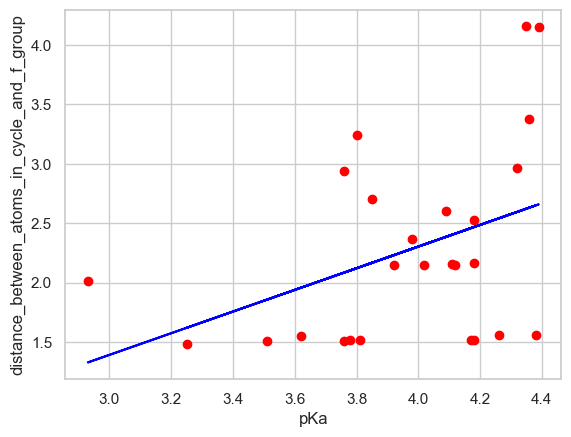

Amount of feature: angle_X1X2R2: 26
R^2 score: 0.08334075827853218
{'mse': 205.174, 'mae': 12.599, 'r_score': 0.083}


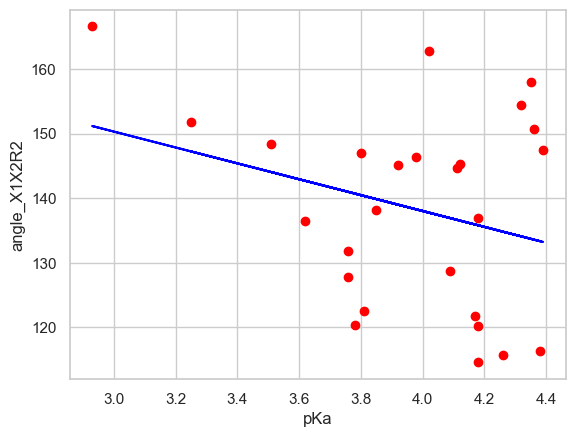

Amount of feature: nF: 3
Kruskal for nF: 23.86
P-value: 0.0000
There is a statistically significant difference between the groups


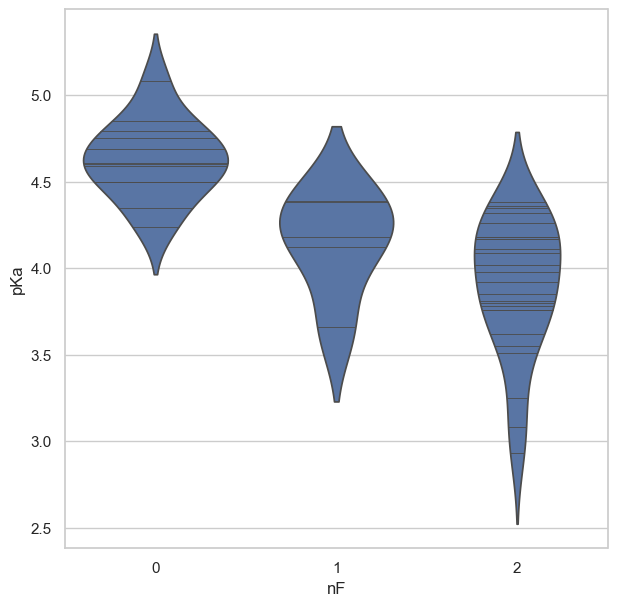

Amount of feature: angle_R1X1R2: 26
R^2 score: 0.002107056850706009
{'mse': 585.068, 'mae': 19.518, 'r_score': 0.002}


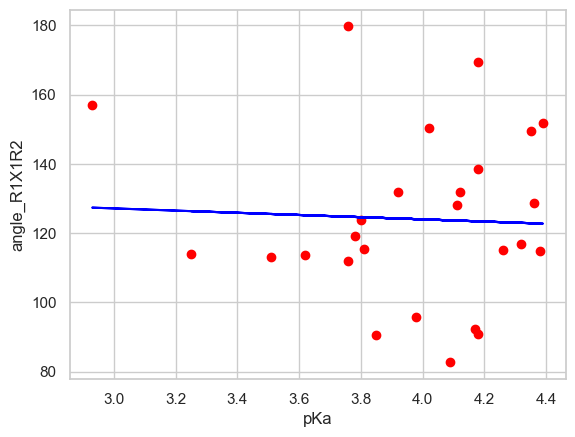

Amount of feature: PNSA5: 43
R^2 score: 0.4687383735811766
{'mse': 45.112, 'mae': 5.39, 'r_score': 0.469}


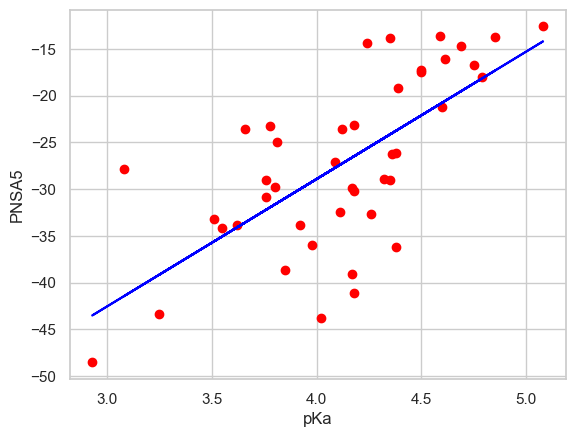

Amount of feature: TASA: 43
R^2 score: 0.36429014190999087
{'mse': 705.258, 'mae': 20.916, 'r_score': 0.364}


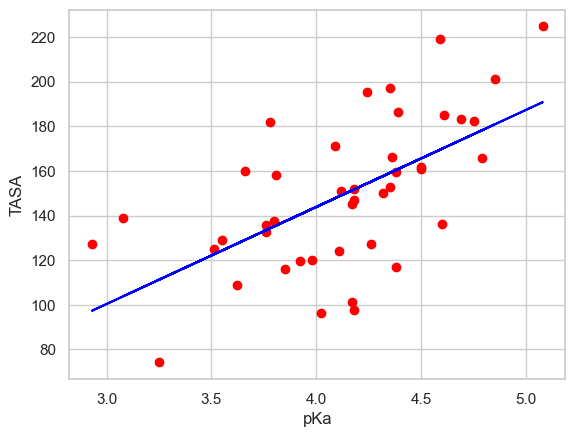

Amount of feature: angle_R2X2R1: 26
R^2 score: 0.00021862585811150851
{'mse': 452.278, 'mae': 16.513, 'r_score': 0.0}


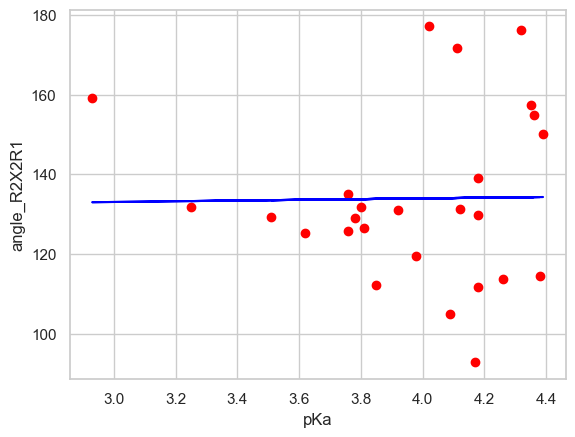

Amount of feature: distance_between_atoms_in_f_group_centers: 26
R^2 score: 0.09718884971226707
{'mse': 0.907, 'mae': 0.813, 'r_score': 0.097}


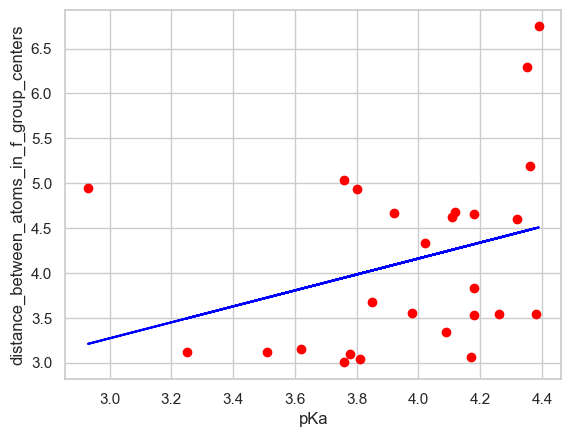

Amount of feature: angle_X2X1R1: 26
R^2 score: 0.0165532538978874
{'mse': 398.178, 'mae': 17.069, 'r_score': 0.017}


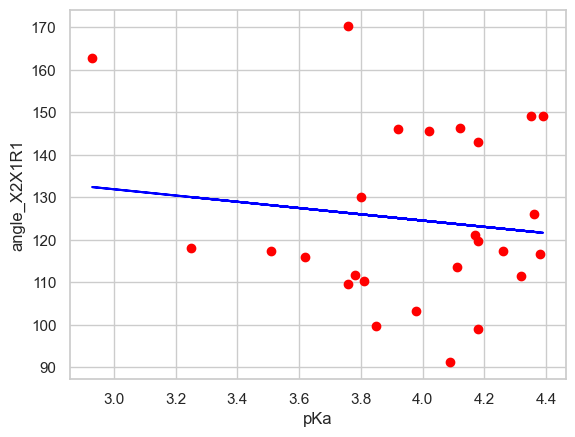

Amount of feature: f_to_fg: 3
Kruskal for f_to_fg: 22.94
P-value: 0.0000
There is a statistically significant difference between the groups


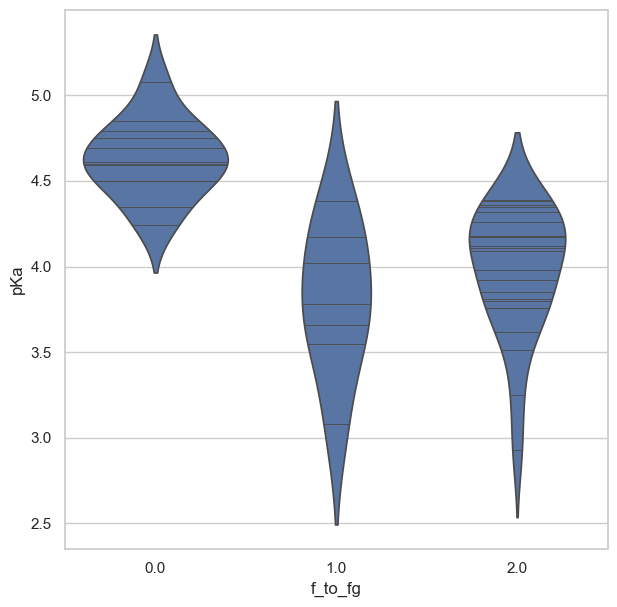

Amount of feature: mol_weight: 21
R^2 score: 0.20054113355360528
{'mse': 421.111, 'mae': 16.506, 'r_score': 0.201}


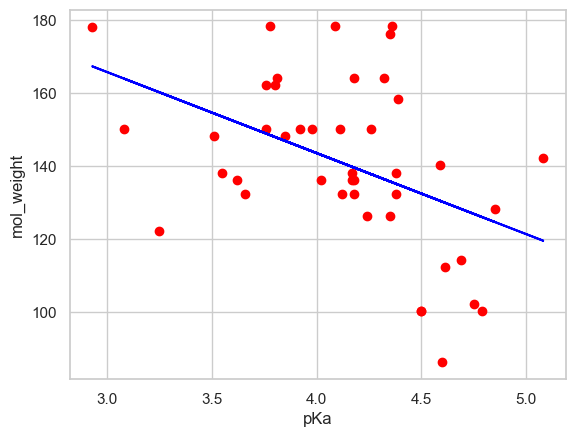

Amount of feature: avg_atoms_in_cycle: 9
Kruskal for avg_atoms_in_cycle: 6.50
P-value: 0.5912
There isn't any statistically significant difference between the groups


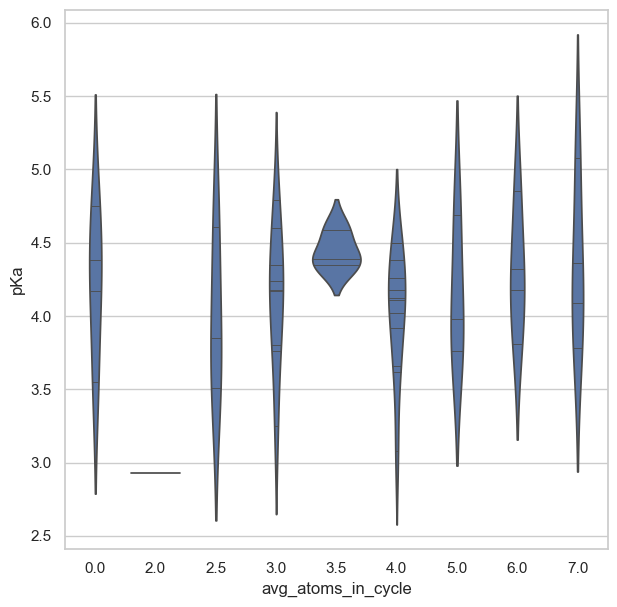

Amount of feature: FPSA3: 43
R^2 score: 0.02407681605265775
{'mse': 0.0, 'mae': 0.003, 'r_score': 0.024}


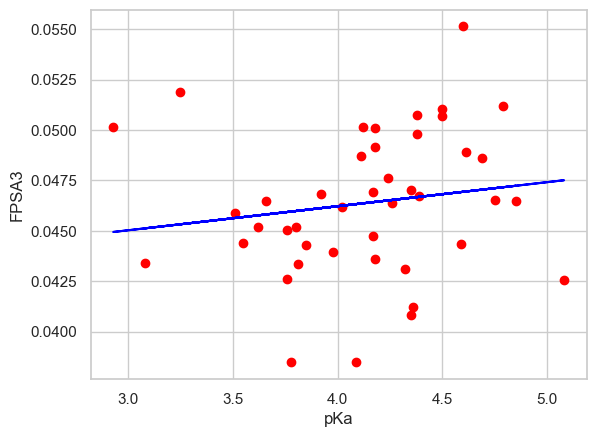

Amount of feature: sasa: 43
R^2 score: 0.0011370135244682773
{'mse': 553.015, 'mae': 18.186, 'r_score': 0.001}


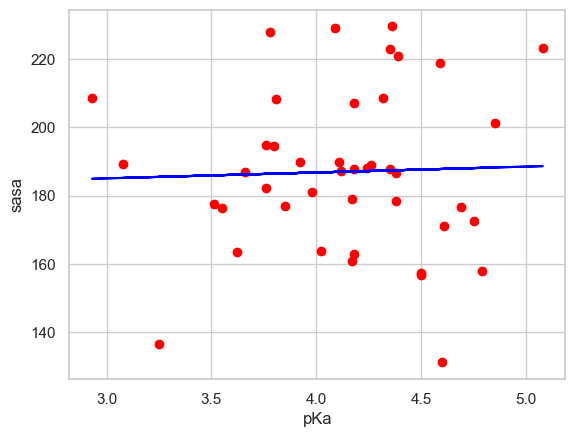

Amount of feature: TASA: 43
R^2 score: 0.36429014190999087
{'mse': 705.258, 'mae': 20.916, 'r_score': 0.364}


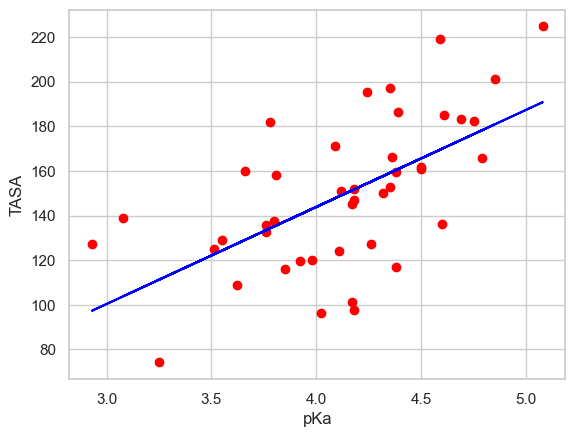

Amount of feature: nC: 5
Kruskal for nC: 3.72
P-value: 0.4454
There isn't any statistically significant difference between the groups


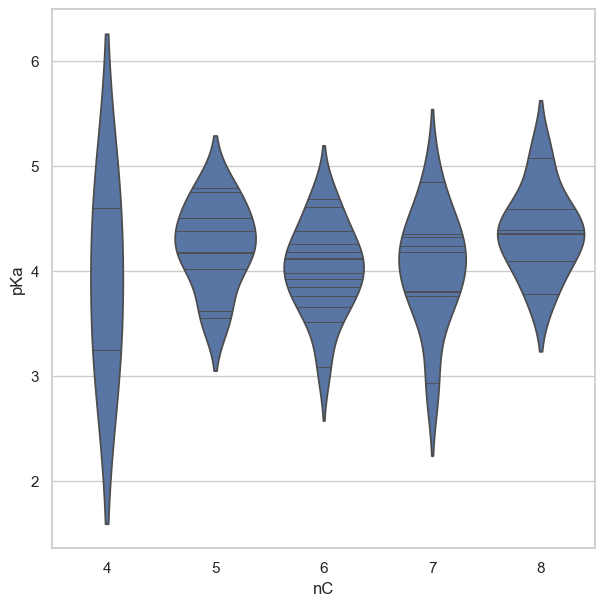

Amount of feature: dipole_moment: 43
R^2 score: 0.2487522188794041
{'mse': 0.018, 'mae': 0.1, 'r_score': 0.249}


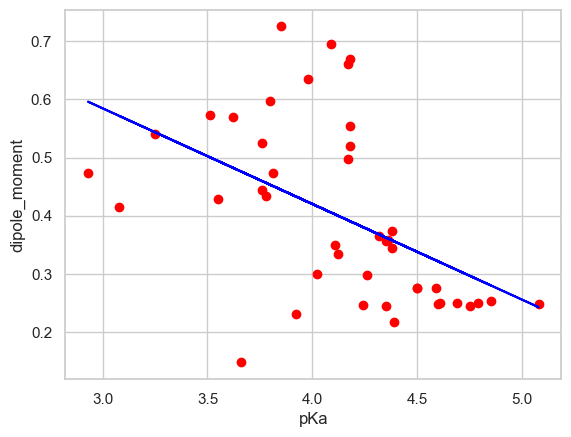

Amount of feature: FPSA3: 43
R^2 score: 0.02407681605265775
{'mse': 0.0, 'mae': 0.003, 'r_score': 0.024}


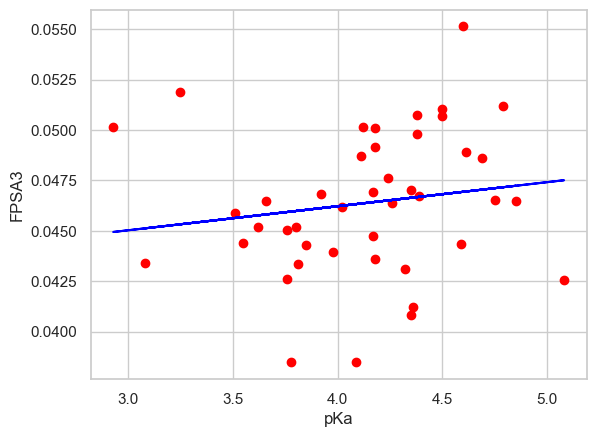

Amount of feature: nF: 3
Kruskal for nF: 23.86
P-value: 0.0000
There is a statistically significant difference between the groups


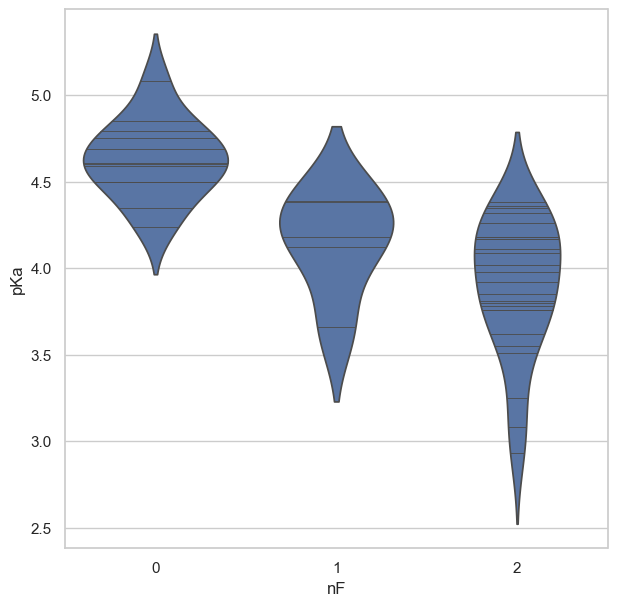

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 87.00
P-value: 0.0007
There is a statistically significant difference between the groups


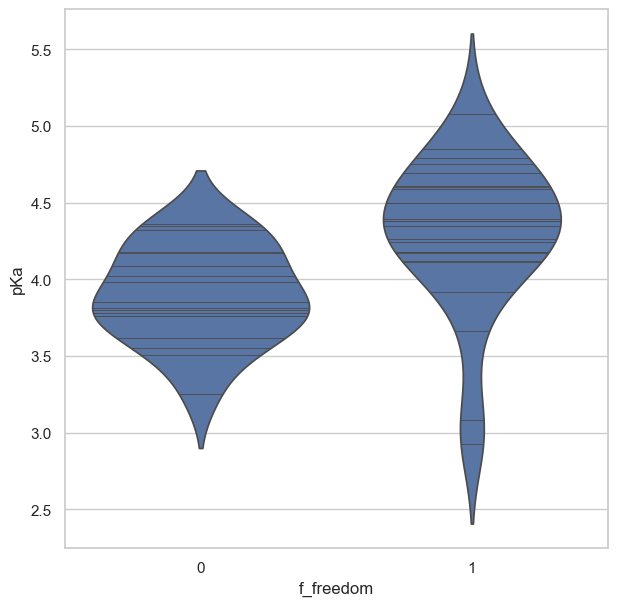

Amount of feature: nHRing: 2
Mann-Whitney U for nHRing: 42.00
P-value: 0.0984
There isn't any statistically significant difference between the groups


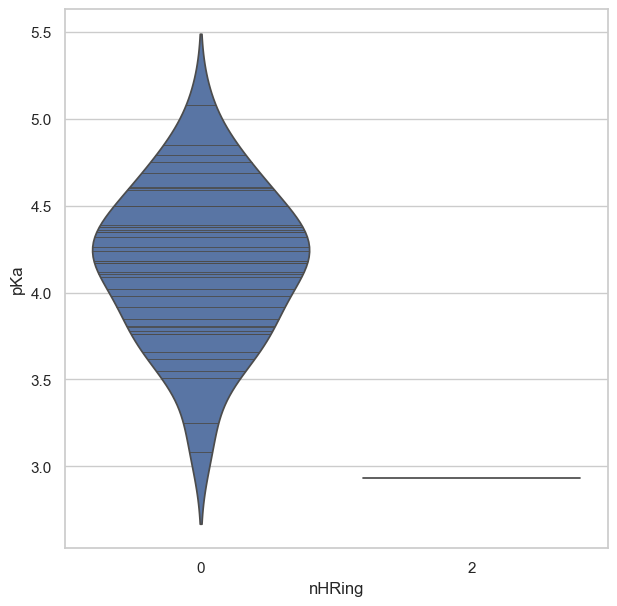

Amount of feature: nO: 2
Mann-Whitney U for nO: 42.00
P-value: 0.0984
There isn't any statistically significant difference between the groups


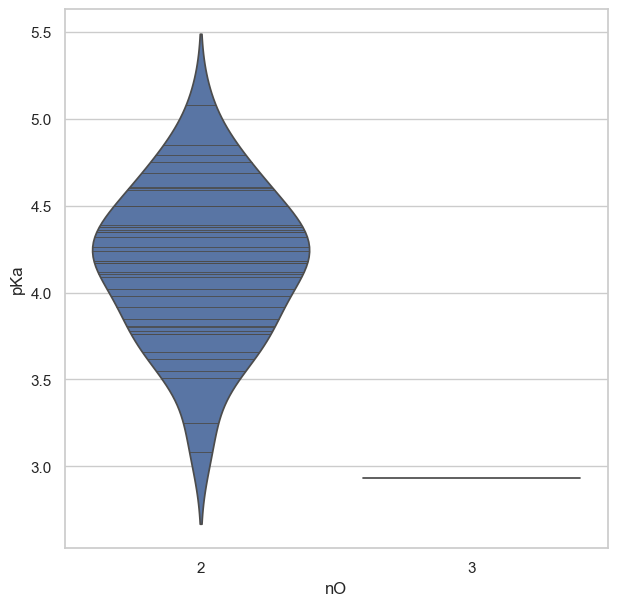

Amount of feature: mol_num_cycles: 4
Kruskal for mol_num_cycles: 2.96
P-value: 0.3984
There isn't any statistically significant difference between the groups


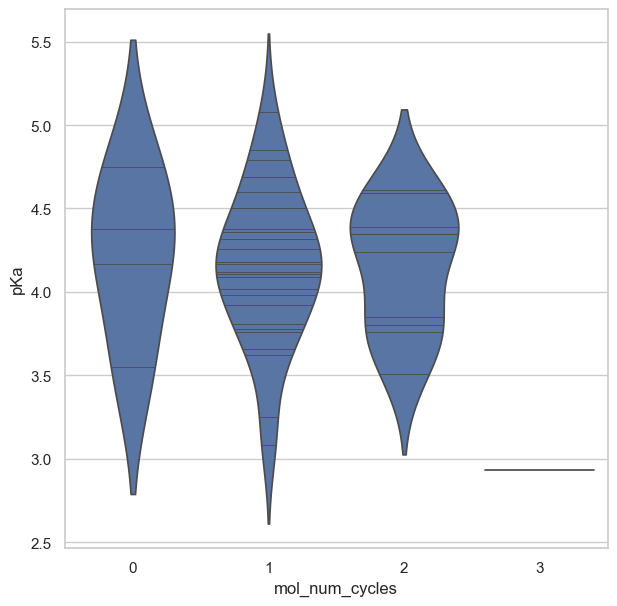

Amount of feature: nARing: 4
Kruskal for nARing: 2.96
P-value: 0.3984
There isn't any statistically significant difference between the groups


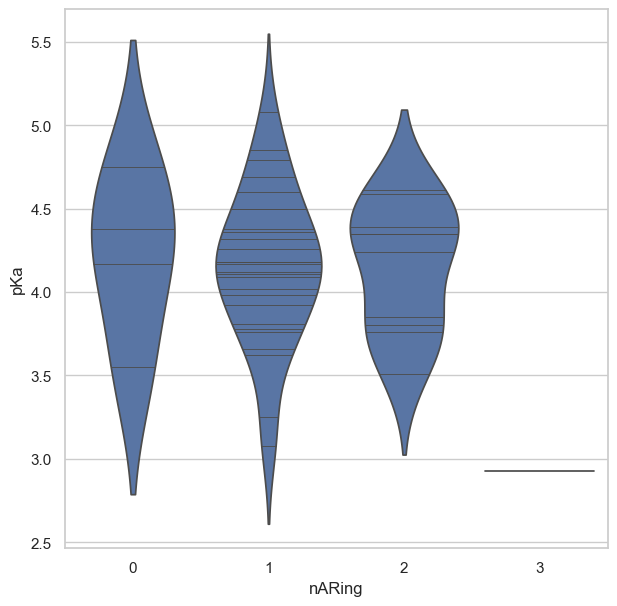

Amount of feature: cis/trans: 3
Kruskal for cis/trans: 0.97
P-value: 0.6146
There isn't any statistically significant difference between the groups


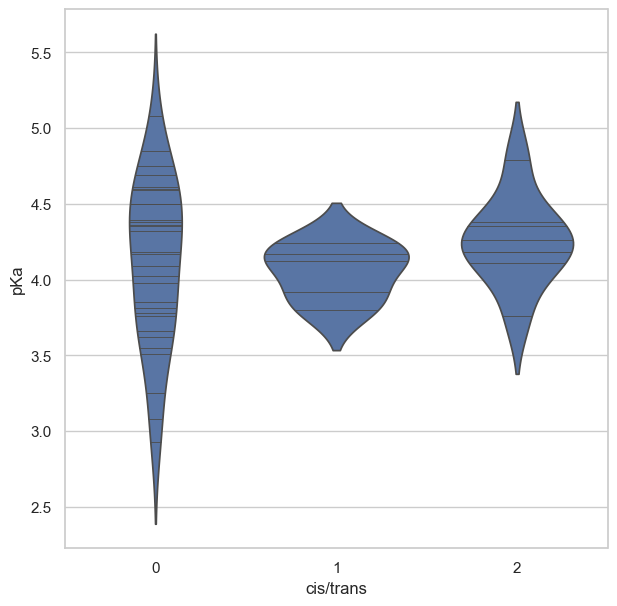

Amount of feature: chirality: 4
Kruskal for chirality: 5.52
P-value: 0.1374
There isn't any statistically significant difference between the groups


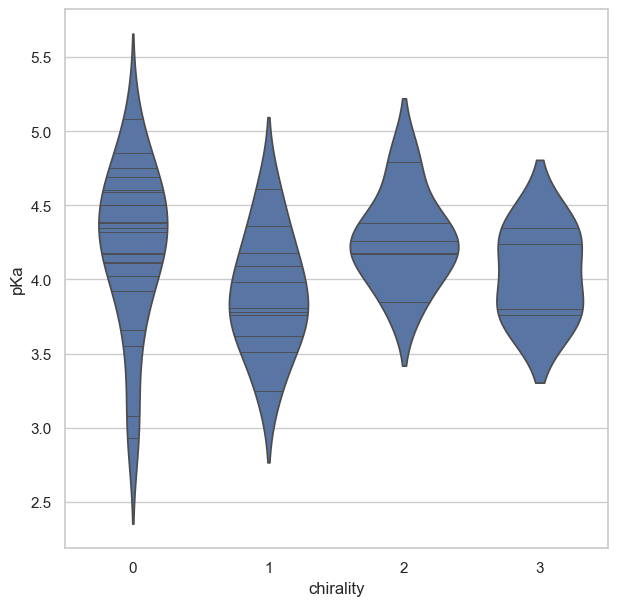

Amount of feature: nFRing: 2
Mann-Whitney U for nFRing: 131.00
P-value: 0.1785
There isn't any statistically significant difference between the groups


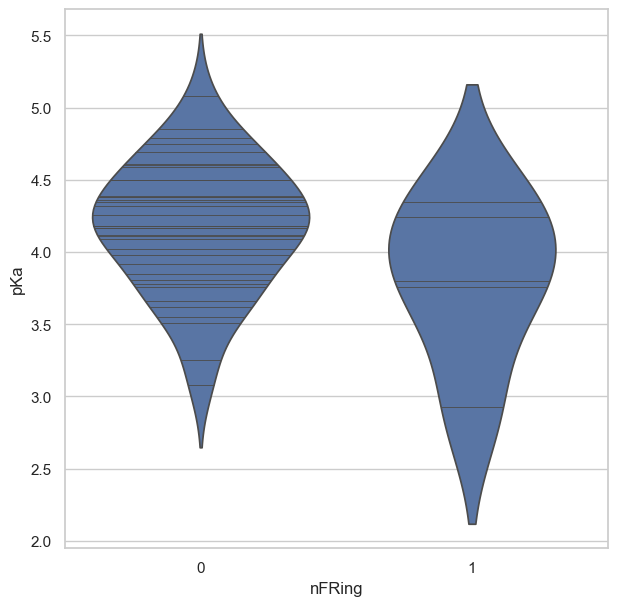

Amount of feature: PBF: 43
R^2 score: 0.04593740582871272
{'mse': 0.006, 'mae': 0.068, 'r_score': 0.046}


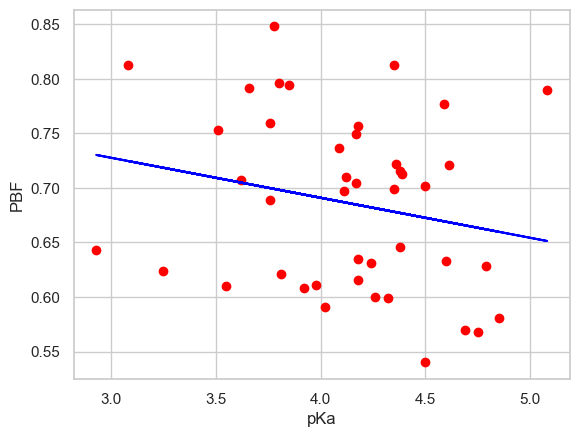

Amount of feature: PPSA5: 43
R^2 score: 0.4035798509174571
{'mse': 0.303, 'mae': 0.419, 'r_score': 0.404}


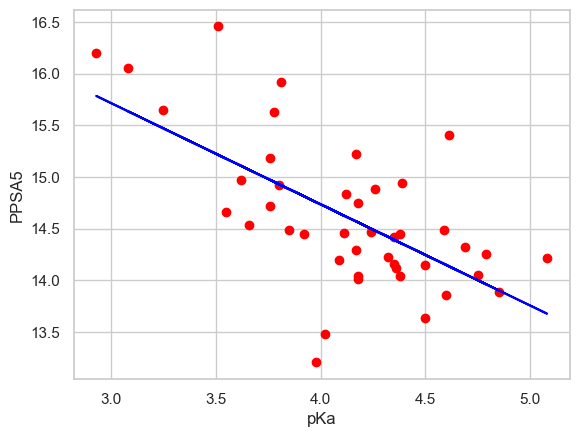

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.5:
            continue

        if feature_names[feature_index] == 'pKa':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, pKa repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            print(f"R^2 score: {pow(r, 2)}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('pKa')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['pKa']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='pKa',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                
